<a href="https://colab.research.google.com/github/jpsicilia/chess_data_lab/blob/main/chess_data_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importar Librerias

In [42]:
import csv
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
def limpiar_csv_con_csv_reader(ruta_entrada, ruta_salida):
    with open(ruta_entrada, 'r', encoding='utf-8') as infile, \
         open(ruta_salida, 'w', encoding='utf-8', newline='') as outfile:

        reader = csv.reader(infile)
        writer = csv.writer(outfile)

        num_columnas = None
        filas_validas = 0
        filas_saltadas = 0

        for i, row in enumerate(reader):
            if num_columnas is None:
                num_columnas = len(row)
                writer.writerow(row)  # Escribo cabecera
            else:
                if len(row) == num_columnas:
                    writer.writerow(row)
                    filas_validas += 1
                else:
                    filas_saltadas += 1
                    print(f"Salteando fila {i+1} por cantidad incorrecta de columnas ({len(row)} vs {num_columnas})")

    print(f"Filas válidas: {filas_validas}")
    print(f"Filas saltadas: {filas_saltadas}")

ruta_original = 'games_wgm.csv'
ruta_limpia = 'games_wgm_limpio.csv'

limpiar_csv_con_csv_reader(ruta_original, ruta_limpia)

df = pd.read_csv(ruta_limpia)
print(df.shape)


Filas válidas: 304767
Filas saltadas: 0
(304767, 15)


In [44]:
df=pd.read_csv('games_wgm_limpio.csv')

In [45]:
df.isna().sum()

,0
game_id,0
game_url,0
pgn,3473
time_control,0
end_time,0
rated,0
time_class,0
rules,0
wgm_username,0
white_username,0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304767 entries, 0 to 304766
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   game_id         304767 non-null  object
 1   game_url        304767 non-null  object
 2   pgn             301294 non-null  object
 3   time_control    304767 non-null  object
 4   end_time        304767 non-null  object
 5   rated           304767 non-null  bool  
 6   time_class      304767 non-null  object
 7   rules           304767 non-null  object
 8   wgm_username    304767 non-null  object
 9   white_username  304767 non-null  object
 10  white_rating    304767 non-null  int64 
 11  white_result    304767 non-null  object
 12  black_username  304767 non-null  object
 13  black_rating    304767 non-null  int64 
 14  black_result    304767 non-null  object
dtypes: bool(1), int64(2), object(12)
memory usage: 32.8+ MB


In [47]:
def extract_opening(pgn_text):
    if pd.isna(pgn_text):
        return pd.Series(["Unknown", "Unknown"])

    eco = re.search(r'\[ECO "(.*?)"\]', pgn_text)
    eco = eco.group(1) if eco else "Unknown"

    eco_url = re.search(r'\[ECOUrl "(.*?)"\]', pgn_text)
    eco_url = eco_url.group(1) if eco_url else "Unknown"

    if eco_url != "Unknown":
        opening_name = eco_url.split("/")[-1].replace("-", " ").capitalize()
    else:
        opening_name = "Unknown"

    return pd.Series([eco, opening_name])
df[['eco_code', 'opening_name']] = df['pgn'].apply(extract_opening)

In [48]:
df.head()

,game_id,game_url,pgn,time_control,end_time,rated,time_class,rules,wgm_username,white_username,white_rating,white_result,black_username,black_rating,black_result,eco_code,opening_name
0,372626070,https://www.chess.com/live/game/372626070,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",4500+30,2012-10-04 09:30:50,True,rapid,chess,abrahamyan-la,Getz-DAL,2577,win,Abrahamyan-LA,2262,resigned,C03,French defense tarrasch morozevich variation 4...
1,376650570,https://www.chess.com/live/game/376650570,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",3600+30,2012-10-11 09:14:01,False,rapid,chess,abrahamyan-la,Martirosov-BOS,2345,win,Abrahamyan-LA,2262,resigned,E60,Kings indian defense 3.nf3
2,593979727,https://www.chess.com/live/game/593979727,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",4500+30,2013-09-05 09:54:49,False,rapid,chess,abrahamyan-la,Abrahamyan-LA,2429,win,Sinanan-SEA,2246,resigned,B47,Sicilian defense taimanov bastrikov variation ...
3,613859708,https://www.chess.com/live/game/613859708,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",3600+30,2013-10-03 09:03:48,False,rapid,chess,abrahamyan-la,Abrahamyan-LA,2429,repetition,Cunningham-CAR,2225,repetition,B04,Alekhines defense modern alburt variation 5.bc4
4,634471928,https://www.chess.com/live/game/634471928,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",4500+30,2013-10-31 09:38:10,False,rapid,chess,abrahamyan-la,Molner-ARZ,2592,win,Abrahamyan-LA,2429,resigned,E10,Indian game east indian anti nimzo indian vari...


<ipython-input-49-50c3d3ef9046>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




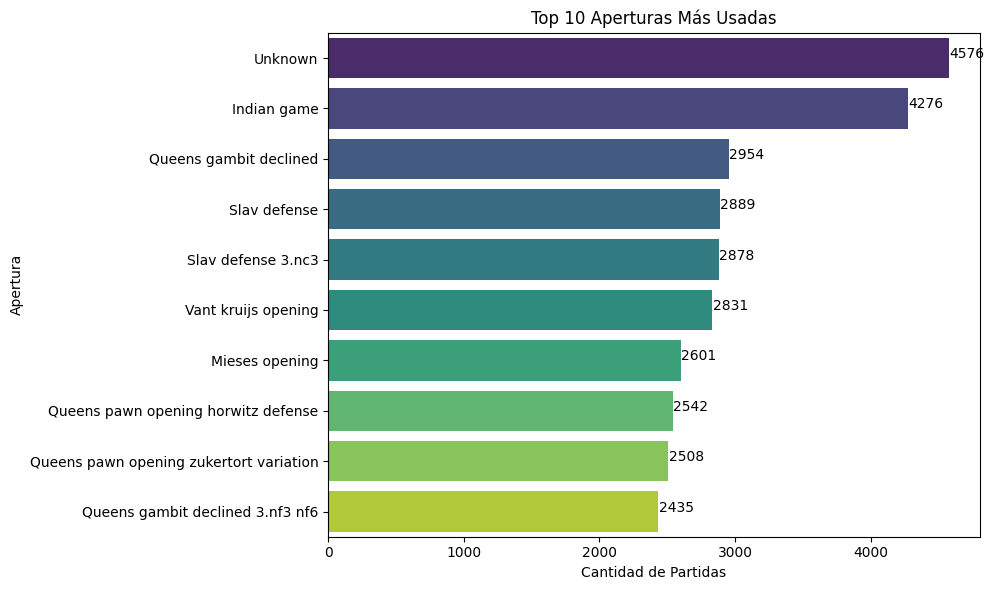

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración básica
plt.figure(figsize=(10, 6))
top_openings = df['opening_name'].value_counts().head(10)

# Gráfico de barras simple
ax = sns.barplot(x=top_openings.values, y=top_openings.index, palette='viridis')

# Añadir etiquetas
plt.title('Top 10 Aperturas Más Usadas')
plt.xlabel('Cantidad de Partidas')
plt.ylabel('Apertura')

# Mostrar valores en las barras
for i, v in enumerate(top_openings.values):
    ax.text(v + 3, i, str(v), color='black')

plt.tight_layout()
plt.show()